<a href="https://colab.research.google.com/github/hadifarahani/Advanced-ML-SBU/blob/main/PPO_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Required imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import seaborn as sns
from scipy.signal import lfilter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


Using device: cuda


In [12]:
class PolicyNetwork(nn.Module):
    """
    Policy network for continuous action spaces.
    Outputs mean and log_std for a Gaussian policy.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std_head = nn.Linear(hidden_dim, action_dim)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=1.0)
            nn.init.zeros_(m.bias)

    def forward(self, state):
        x = F.tanh(self.fc1(state))
        x = F.tanh(self.fc2(x))
        mean = self.mean_head(x)
        log_std = self.log_std_head(x)

        # Clamp log_std for numerical stability
        log_std = torch.clamp(log_std, -20, 2)

        return mean, log_std

    def act(self, state):
        """Sample action from policy"""
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        return action, log_prob

    def log_prob(self, state, action):
        """Compute log probability of action"""
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        return dist.log_prob(action).sum(dim=-1)

    def entropy(self, state):
        """Compute policy entropy"""
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        return dist.entropy().sum(dim=-1)


class ValueNetwork(nn.Module):
    """
    Value network for state value estimation.
    """
    def __init__(self, state_dim, hidden_dim=64):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_head = nn.Linear(hidden_dim, 1)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=1.0)
            nn.init.zeros_(m.bias)

    def forward(self, state):
        x = F.tanh(self.fc1(state))
        x = F.tanh(self.fc2(x))
        value = self.value_head(x)
        return value.squeeze()


# Test the networks
print("Testing networks...")
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

policy_net = PolicyNetwork(state_dim, action_dim).to(device)
value_net = ValueNetwork(state_dim).to(device)

# Test with dummy data
dummy_state = torch.randn(1, state_dim).to(device)
action, log_prob = policy_net.act(dummy_state)
value = value_net(dummy_state)
entropy = policy_net.entropy(dummy_state)

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Sample action: {action.cpu().numpy().flatten()}")
print(f"Log probability: {log_prob.item():.4f}")
print(f"State value: {value.item():.4f}")
print(f"Policy entropy: {entropy.item():.4f}")
print("Networks initialized successfully!")


Testing networks...
State dimension: 3
Action dimension: 1
Sample action: [0.4555006]
Log probability: -1.0291
State value: 0.1125
Policy entropy: 1.5103
Networks initialized successfully!


In [13]:
def discount_cumsum(x, discount):
    """
    Compute discounted cumulative sums of vectors.
    Used for computing discounted returns and advantages.
    """
    return lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


def compute_gae(rewards, values, next_values, gamma=0.99, lam=0.95):
    """
    Compute Generalized Advantage Estimation (GAE).

    Args:
        rewards: List of rewards
        values: List of state values
        next_values: List of next state values
        gamma: Discount factor
        lam: GAE lambda parameter
    """
    deltas = rewards + gamma * next_values - values
    advantages = discount_cumsum(deltas, gamma * lam)
    returns = advantages + values
    return advantages, returns


def compute_returns(rewards, gamma=0.99):
    """
    Compute discounted returns (Monte Carlo).

    Args:
        rewards: List of rewards
        gamma: Discount factor
    """
    returns = discount_cumsum(rewards, gamma)
    return returns


def normalize_advantages(advantages):
    """
    Normalize advantages to have zero mean and unit variance.
    This helps with training stability.
    """
    advantages = np.array(advantages)
    return (advantages - advantages.mean()) / (advantages.std() + 1e-8)


def explained_variance(y_pred, y_true):
    """
    Compute explained variance for value function evaluation.
    """
    var_y = np.var(y_true)
    return 1.0 - np.var(y_true - y_pred) / var_y if var_y > 0 else 0.0


def compute_kl_divergence(old_log_probs, new_log_probs):
    """
    Compute KL divergence between old and new policies.
    """
    # KL(old || new) = E[log(old) - log(new)]
    kl = (old_log_probs - new_log_probs).mean()
    return kl


print("Utility functions implemented successfully!")


Utility functions implemented successfully!


In [14]:
class PPOAgent:
    """
    Proximal Policy Optimization Agent
    """
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, lam=0.95,
                 epsilon=0.2, value_coeff=0.5, entropy_coeff=0.01,
                 max_grad_norm=0.5, ppo_epochs=4, batch_size=64,
                 target_kl=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.lam = lam
        self.epsilon = epsilon
        self.value_coeff = value_coeff
        self.entropy_coeff = entropy_coeff
        self.max_grad_norm = max_grad_norm
        self.ppo_epochs = ppo_epochs
        self.batch_size = batch_size
        self.target_kl = target_kl

        # Initialize networks
        self.policy_net = PolicyNetwork(state_dim, action_dim).to(device)
        self.value_net = ValueNetwork(state_dim).to(device)

        # Optimizer
        self.optimizer = optim.Adam(
            list(self.policy_net.parameters()) + list(self.value_net.parameters()),
            lr=lr
        )

        # Store for logging
        self.training_stats = {
            'episode_rewards': [],
            'episode_lengths': [],
            'policy_losses': [],
            'value_losses': [],
            'entropy_losses': [],
            'kl_divergences': [],
            'clipfracs': [],
            'explained_variances': []
        }

    def collect_trajectories(self, env, min_batch_size=2048):
        """
        Collect trajectories using current policy
        """
        trajectories = []
        total_steps = 0

        while total_steps < min_batch_size:
            trajectory = {
                'states': [],
                'actions': [],
                'rewards': [],
                'log_probs': [],
                'values': [],
                'done': []
            }

            state, _ = env.reset()
            done = False

            while not done:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

                with torch.no_grad():
                    action, log_prob = self.policy_net.act(state_tensor)
                    value = self.value_net(state_tensor)

                action_np = action.cpu().numpy().flatten()
                next_state, reward, terminated, truncated, _ = env.step(action_np)
                done = terminated or truncated

                trajectory['states'].append(state)
                trajectory['actions'].append(action_np)
                trajectory['rewards'].append(reward)
                trajectory['log_probs'].append(log_prob.item())
                trajectory['values'].append(value.item())
                trajectory['done'].append(done)

                state = next_state
                total_steps += 1

            trajectories.append(trajectory)

        return trajectories

    def process_trajectories(self, trajectories):
        """
        Process trajectories to compute advantages and returns
        """
        states, actions, rewards, log_probs, values, advantages, returns = [], [], [], [], [], [], []

        for trajectory in trajectories:
            traj_rewards = np.array(trajectory['rewards'])
            traj_values = np.array(trajectory['values'])

            # Compute advantages using GAE
            next_values = np.zeros_like(traj_values)
            next_values[:-1] = traj_values[1:]
            traj_advantages, traj_returns = compute_gae(
                traj_rewards, traj_values, next_values, self.gamma, self.lam
            )

            states.extend(trajectory['states'])
            actions.extend(trajectory['actions'])
            rewards.extend(trajectory['rewards'])
            log_probs.extend(trajectory['log_probs'])
            values.extend(trajectory['values'])
            advantages.extend(traj_advantages)
            returns.extend(traj_returns)

        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.FloatTensor(np.array(actions)).to(device)
        old_log_probs = torch.FloatTensor(np.array(log_probs)).to(device)
        values = torch.FloatTensor(np.array(values)).to(device)
        advantages = torch.FloatTensor(np.array(advantages)).to(device)
        returns = torch.FloatTensor(np.array(returns)).to(device)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        return states, actions, advantages, returns, old_log_probs

    def ppo_update(self, states, actions, advantages, returns, old_log_probs):
        """
        Perform PPO update with multiple epochs
        """
        policy_losses = []
        value_losses = []
        entropy_losses = []
        kl_divs = []
        clipfracs = []

        # Create dataset
        dataset_size = len(states)
        indices = np.arange(dataset_size)

        for epoch in range(self.ppo_epochs):
            # Shuffle data
            np.random.shuffle(indices)

            # Create mini-batches
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_indices = indices[start:end]

                # Get batch data
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]

                # Compute current log probabilities and values
                current_log_probs = self.policy_net.log_prob(batch_states, batch_actions)
                current_values = self.value_net(batch_states)
                entropy = self.policy_net.entropy(batch_states)

                # Compute probability ratio
                ratio = torch.exp(current_log_probs - batch_old_log_probs)

                # Compute clipped surrogate loss
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Compute value loss
                value_loss = F.mse_loss(current_values, batch_returns)

                # Compute entropy loss
                entropy_loss = -entropy.mean()

                # Combined loss
                total_loss = (policy_loss +
                             self.value_coeff * value_loss +
                             self.entropy_coeff * entropy_loss)

                # Update parameters
                self.optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    list(self.policy_net.parameters()) + list(self.value_net.parameters()),
                    self.max_grad_norm
                )
                self.optimizer.step()

                # Compute KL divergence
                with torch.no_grad():
                    kl_div = compute_kl_divergence(batch_old_log_probs, current_log_probs)

                    # Compute clipping fraction
                    clipfrac = ((ratio - 1.0).abs() > self.epsilon).float().mean()

                # Store losses
                policy_losses.append(policy_loss.item())
                value_losses.append(value_loss.item())
                entropy_losses.append(entropy_loss.item())
                kl_divs.append(kl_div.item())
                clipfracs.append(clipfrac.item())

            # Early stopping if KL divergence is too large
            if np.mean(kl_divs) > self.target_kl:
                break

        return (np.mean(policy_losses), np.mean(value_losses),
                np.mean(entropy_losses), np.mean(kl_divs), np.mean(clipfracs))

    def train_step(self, env, min_batch_size=2048):
        """
        Perform one training step
        """
        # Collect trajectories
        trajectories = self.collect_trajectories(env, min_batch_size)

        # Process trajectories
        states, actions, advantages, returns, old_log_probs = self.process_trajectories(trajectories)

        # PPO update
        policy_loss, value_loss, entropy_loss, kl_div, clipfrac = self.ppo_update(
            states, actions, advantages, returns, old_log_probs
        )

        # Compute explained variance
        with torch.no_grad():
            predicted_values = self.value_net(states)
            explained_var = explained_variance(
                predicted_values.cpu().numpy(),
                returns.cpu().numpy()
            )

        # Log statistics
        episode_rewards = [sum(traj['rewards']) for traj in trajectories]
        episode_lengths = [len(traj['rewards']) for traj in trajectories]

        self.training_stats['episode_rewards'].extend(episode_rewards)
        self.training_stats['episode_lengths'].extend(episode_lengths)
        self.training_stats['policy_losses'].append(policy_loss)
        self.training_stats['value_losses'].append(value_loss)
        self.training_stats['entropy_losses'].append(entropy_loss)
        self.training_stats['kl_divergences'].append(kl_div)
        self.training_stats['clipfracs'].append(clipfrac)
        self.training_stats['explained_variances'].append(explained_var)

        return {
            'avg_reward': np.mean(episode_rewards),
            'avg_length': np.mean(episode_lengths),
            'policy_loss': policy_loss,
            'value_loss': value_loss,
            'entropy_loss': entropy_loss,
            'kl_div': kl_div,
            'clipfrac': clipfrac,
            'explained_var': explained_var
        }

print("PPO Agent implemented successfully!")


PPO Agent implemented successfully!


In [15]:
# Training Configuration
config = {
    'env_name': 'Pendulum-v1',
    'max_iterations': 80,
    'min_batch_size': 2048,
    'lr': 3e-4,
    'gamma': 0.99,
    'lam': 0.95,
    'epsilon': 0.2,
    'value_coeff': 0.5,
    'entropy_coeff': 0.01,
    'max_grad_norm': 0.5,
    'ppo_epochs': 4,
    'batch_size': 64,
    'target_kl': 0.01
}

# Create environment and agent
env = gym.make(config['env_name'])
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(f"Environment: {config['env_name']}")
print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

# Initialize PPO agent
agent = PPOAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=config['lr'],
    gamma=config['gamma'],
    lam=config['lam'],
    epsilon=config['epsilon'],
    value_coeff=config['value_coeff'],
    entropy_coeff=config['entropy_coeff'],
    max_grad_norm=config['max_grad_norm'],
    ppo_epochs=config['ppo_epochs'],
    batch_size=config['batch_size'],
    target_kl=config['target_kl']
)

print(f"Agent initialized with {sum(p.numel() for p in agent.policy_net.parameters())} policy parameters")
print(f"Value network has {sum(p.numel() for p in agent.value_net.parameters())} parameters")


Environment: Pendulum-v1
State dimension: 3
Action dimension: 1
Action space: Box(-2.0, 2.0, (1,), float32)
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Agent initialized with 4546 policy parameters
Value network has 4481 parameters


In [16]:
# Training Loop
print("Starting PPO training...")
print("="*50)

training_log = []

for iteration in range(config['max_iterations']):
    # Perform one training step
    stats = agent.train_step(env, config['min_batch_size'])

    # Log progress
    training_log.append({
        'iteration': iteration + 1,
        'avg_reward': stats['avg_reward'],
        'avg_length': stats['avg_length'],
        'policy_loss': stats['policy_loss'],
        'value_loss': stats['value_loss'],
        'entropy_loss': stats['entropy_loss'],
        'kl_div': stats['kl_div'],
        'clipfrac': stats['clipfrac'],
        'explained_var': stats['explained_var']
    })

    # Print progress
    if (iteration + 1) % 10 == 0:
        print(f"Iteration {iteration + 1:3d} | "
              f"Avg Reward: {stats['avg_reward']:8.2f} | "
              f"Avg Length: {stats['avg_length']:6.1f} | "
              f"Policy Loss: {stats['policy_loss']:8.4f} | "
              f"Value Loss: {stats['value_loss']:8.4f} | "
              f"KL Div: {stats['kl_div']:8.6f} | "
              f"Clipfrac: {stats['clipfrac']:6.4f}")

print("="*50)
print("Training completed!")

# Convert to DataFrame for easier analysis
training_df = pd.DataFrame(training_log)
print(f"\nFinal Results:")
print(f"Best Average Reward: {training_df['avg_reward'].max():.2f}")
print(f"Final Average Reward: {training_df['avg_reward'].iloc[-1]:.2f}")
print(f"Average KL Divergence: {training_df['kl_div'].mean():.6f}")
print(f"Average Clipfrac: {training_df['clipfrac'].mean():.4f}")
print(f"Final Explained Variance: {training_df['explained_var'].iloc[-1]:.4f}")


Starting PPO training...
Iteration  10 | Avg Reward: -1109.94 | Avg Length:  200.0 | Policy Loss:  -0.0008 | Value Loss: 6897.2173 | KL Div: 0.007945 | Clipfrac: 0.0792
Iteration  20 | Avg Reward: -1102.71 | Avg Length:  200.0 | Policy Loss:   0.0026 | Value Loss: 5992.7118 | KL Div: 0.003856 | Clipfrac: 0.0633
Iteration  30 | Avg Reward: -1153.61 | Avg Length:  200.0 | Policy Loss:   0.0021 | Value Loss: 6132.7089 | KL Div: 0.012045 | Clipfrac: 0.0975
Iteration  40 | Avg Reward: -1067.81 | Avg Length:  200.0 | Policy Loss:   0.0139 | Value Loss: 5070.8466 | KL Div: 0.026552 | Clipfrac: 0.1391
Iteration  50 | Avg Reward: -1268.62 | Avg Length:  200.0 | Policy Loss:   0.0039 | Value Loss: 6836.7222 | KL Div: 0.010098 | Clipfrac: 0.0740
Iteration  60 | Avg Reward: -1129.09 | Avg Length:  200.0 | Policy Loss:   0.0059 | Value Loss: 5312.7514 | KL Div: 0.019052 | Clipfrac: 0.0830
Iteration  70 | Avg Reward: -1194.15 | Avg Length:  200.0 | Policy Loss:   0.0105 | Value Loss: 5943.6816 | KL 

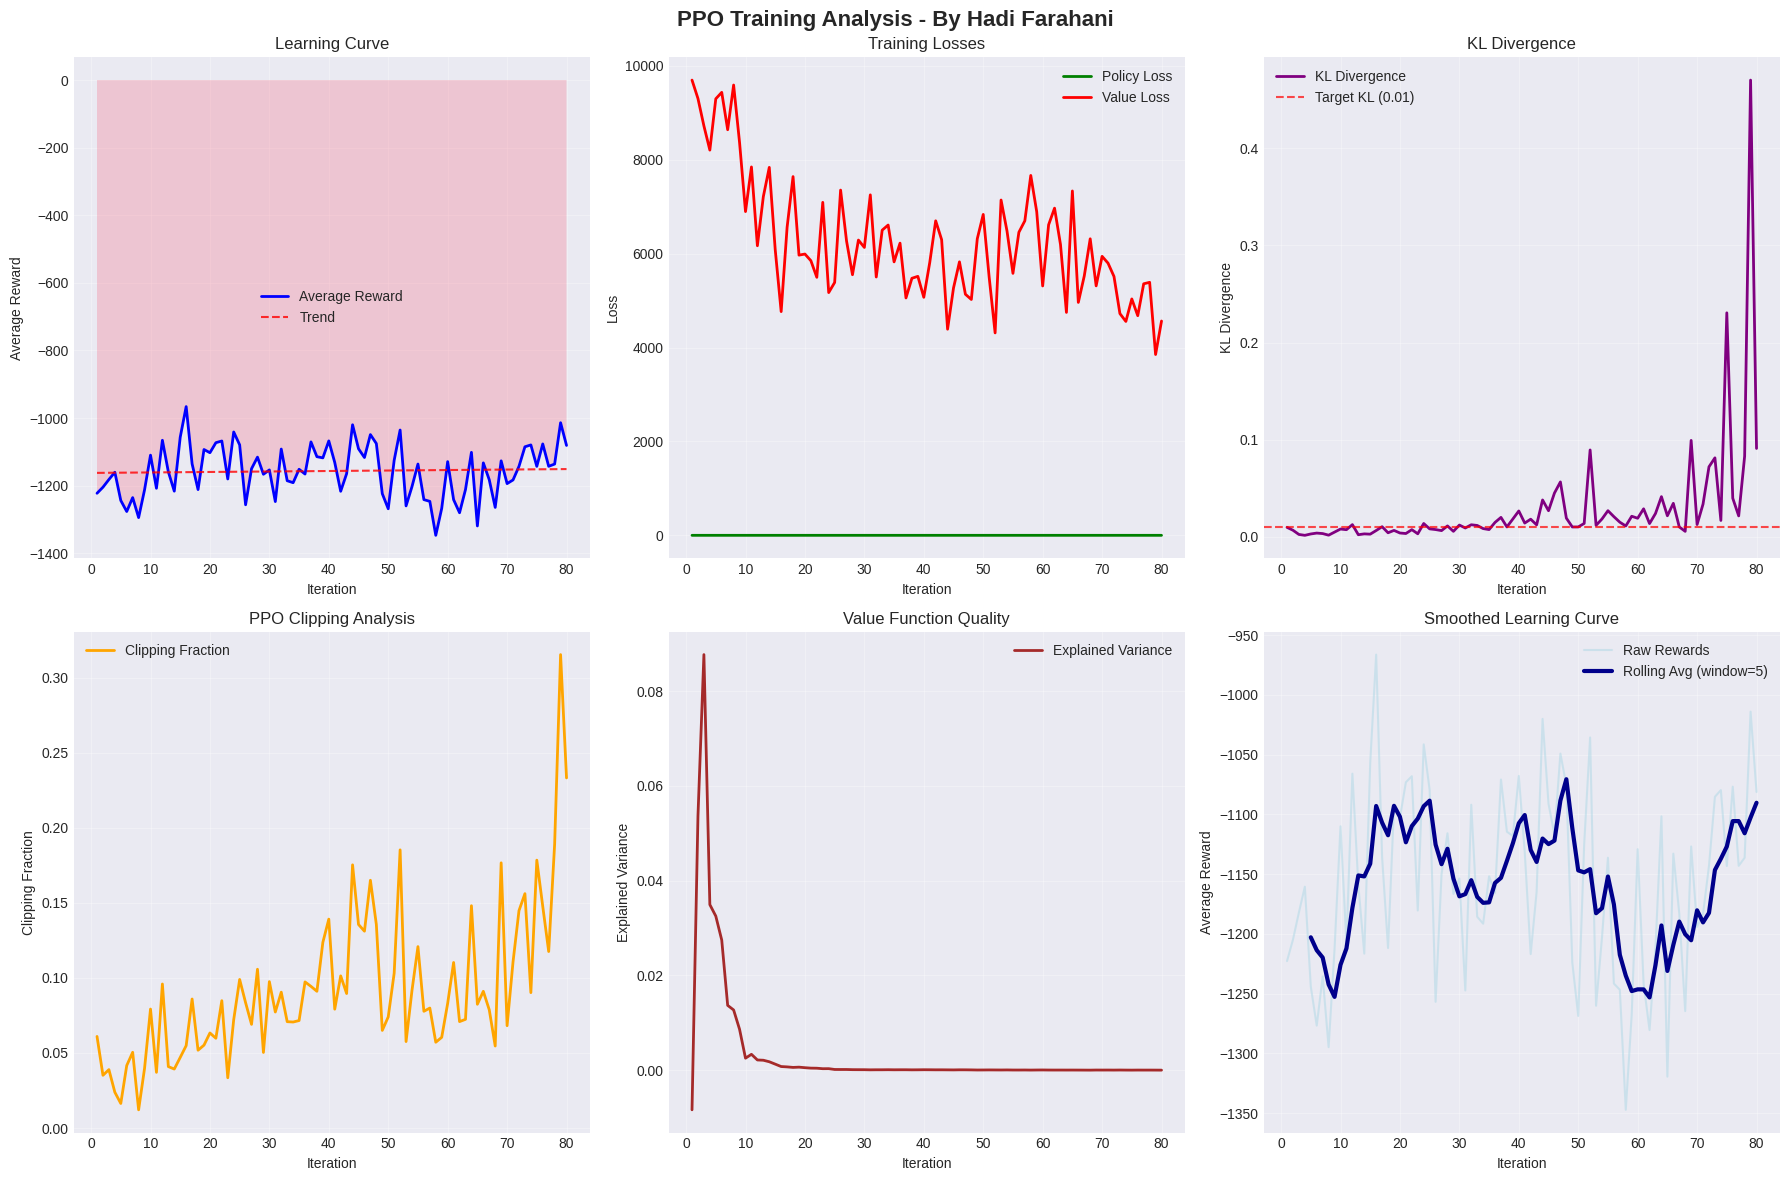

In [17]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PPO Training Analysis', fontsize=16, fontweight='bold')

# 1. Learning Curve (Average Reward)
ax1 = axes[0, 0]
ax1.plot(training_df['iteration'], training_df['avg_reward'], 'b-', linewidth=2, label='Average Reward')
ax1.fill_between(training_df['iteration'], training_df['avg_reward'], alpha=0.3)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average Reward')
ax1.set_title('Learning Curve')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add trend line
z = np.polyfit(training_df['iteration'], training_df['avg_reward'], 1)
p = np.poly1d(z)
ax1.plot(training_df['iteration'], p(training_df['iteration']), 'r--', alpha=0.8, label=f'Trend')
ax1.legend()

# 2. Policy and Value Losses
ax2 = axes[0, 1]
ax2.plot(training_df['iteration'], training_df['policy_loss'], 'g-', linewidth=2, label='Policy Loss')
ax2.plot(training_df['iteration'], training_df['value_loss'], 'r-', linewidth=2, label='Value Loss')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Loss')
ax2.set_title('Training Losses')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. KL Divergence and Clipfrac
ax3 = axes[0, 2]
ax3.plot(training_df['iteration'], training_df['kl_div'], 'purple', linewidth=2, label='KL Divergence')
ax3.axhline(y=config['target_kl'], color='r', linestyle='--', alpha=0.7, label=f'Target KL ({config["target_kl"]})')
ax3.set_xlabel('Iteration')
ax3.set_ylabel('KL Divergence')
ax3.set_title('KL Divergence')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4. Clipping Fraction
ax4 = axes[1, 0]
ax4.plot(training_df['iteration'], training_df['clipfrac'], 'orange', linewidth=2, label='Clipping Fraction')
ax4.set_xlabel('Iteration')
ax4.set_ylabel('Clipping Fraction')
ax4.set_title('PPO Clipping Analysis')
ax4.grid(True, alpha=0.3)
ax4.legend()

# 5. Explained Variance
ax5 = axes[1, 1]
ax5.plot(training_df['iteration'], training_df['explained_var'], 'brown', linewidth=2, label='Explained Variance')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Explained Variance')
ax5.set_title('Value Function Quality')
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6. Rolling Average and Distribution
ax6 = axes[1, 2]
window_size = 5
rolling_avg = training_df['avg_reward'].rolling(window=window_size).mean()
ax6.plot(training_df['iteration'], training_df['avg_reward'], 'lightblue', alpha=0.5, label='Raw Rewards')
ax6.plot(training_df['iteration'], rolling_avg, 'darkblue', linewidth=3, label=f'Rolling Avg (window={window_size})')
ax6.set_xlabel('Iteration')
ax6.set_ylabel('Average Reward')
ax6.set_title('Smoothed Learning Curve')
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.tight_layout()
plt.show()


Evaluating trained policy...
Evaluation Results:
Average Reward: -1124.75 ± 258.34
Average Length: 200.0 ± 0.0
Best Episode: -752.61
Worst Episode: -1656.58


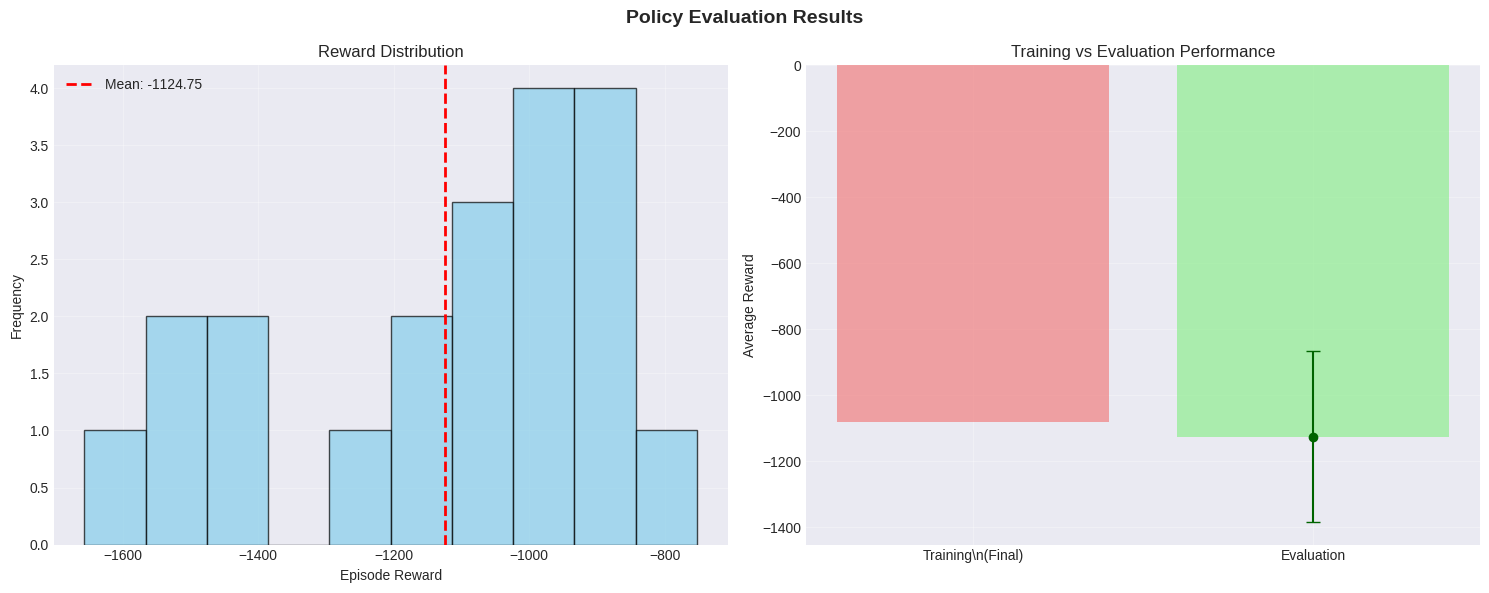

In [18]:
# Additional Analysis: Policy Evaluation and Performance Metrics
def evaluate_policy(agent, env, num_episodes=10):
    """Evaluate the trained policy"""
    episode_rewards = []
    episode_lengths = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action, _ = agent.policy_net.act(state_tensor)

            action_np = action.cpu().numpy().flatten()
            state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated

            episode_reward += reward
            episode_length += 1

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)

    return episode_rewards, episode_lengths

# Evaluate the trained policy
print("Evaluating trained policy...")
eval_rewards, eval_lengths = evaluate_policy(agent, env, num_episodes=20)

print(f"Evaluation Results:")
print(f"Average Reward: {np.mean(eval_rewards):.2f} ± {np.std(eval_rewards):.2f}")
print(f"Average Length: {np.mean(eval_lengths):.1f} ± {np.std(eval_lengths):.1f}")
print(f"Best Episode: {np.max(eval_rewards):.2f}")
print(f"Worst Episode: {np.min(eval_rewards):.2f}")

# Create evaluation visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Policy Evaluation Results', fontsize=14, fontweight='bold')

# Reward distribution
ax1.hist(eval_rewards, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(np.mean(eval_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(eval_rewards):.2f}')
ax1.set_xlabel('Episode Reward')
ax1.set_ylabel('Frequency')
ax1.set_title('Reward Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Performance comparison
ax2.bar(['Training\\n(Final)', 'Evaluation'],
        [training_df['avg_reward'].iloc[-1], np.mean(eval_rewards)],
        color=['lightcoral', 'lightgreen'], alpha=0.7)
ax2.set_ylabel('Average Reward')
ax2.set_title('Training vs Evaluation Performance')
ax2.grid(True, alpha=0.3)

# Add error bars for evaluation
ax2.errorbar(['Evaluation'], [np.mean(eval_rewards)],
             yerr=[np.std(eval_rewards)], fmt='o', color='darkgreen', capsize=5)

plt.tight_layout()
plt.show()


Visualizing policy behavior...


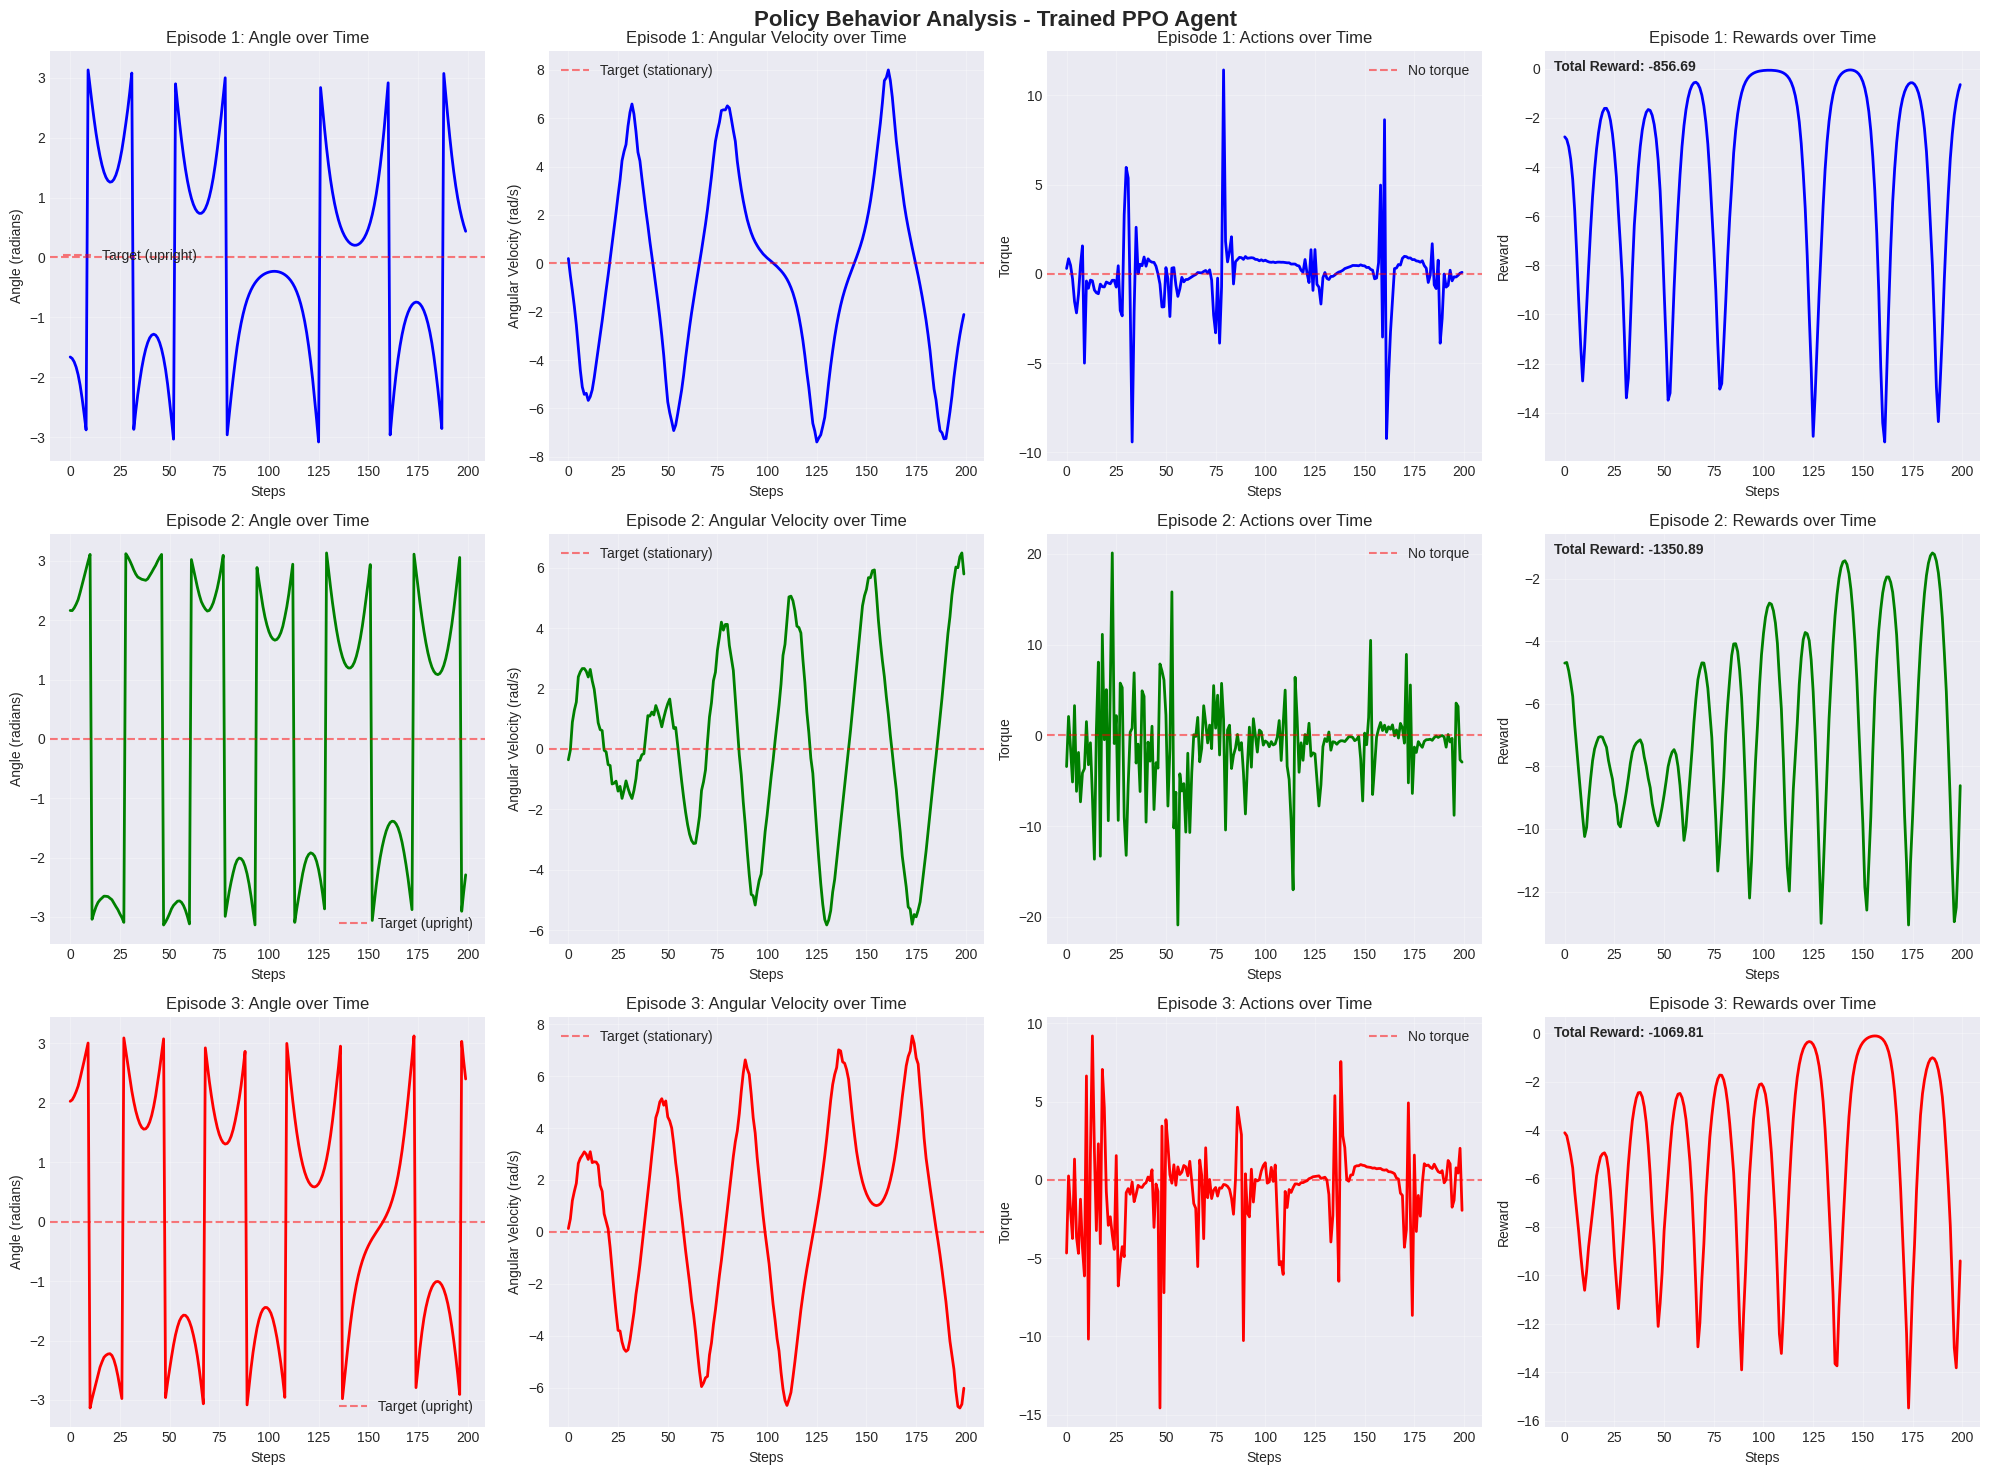

In [19]:
# Visualize Policy Behavior
def visualize_policy_behavior(agent, env, num_episodes=3):
    """Visualize how the policy behaves over time"""
    fig, axes = plt.subplots(num_episodes, 4, figsize=(20, 5*num_episodes))
    if num_episodes == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Policy Behavior Analysis - Trained PPO Agent', fontsize=16, fontweight='bold')

    colors = ['blue', 'green', 'red']

    for episode in range(num_episodes):
        state, _ = env.reset()

        states = []
        actions = []
        rewards = []
        angles = []
        angular_velocities = []

        done = False
        step = 0

        while not done and step < 200:  # Limit to 200 steps
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action, _ = agent.policy_net.act(state_tensor)

            action_np = action.cpu().numpy().flatten()

            # Extract angle and angular velocity from state
            cos_theta, sin_theta, theta_dot = state
            theta = np.arctan2(sin_theta, cos_theta)

            states.append(state.copy())
            actions.append(action_np)
            angles.append(theta)
            angular_velocities.append(theta_dot)

            state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated
            rewards.append(reward)
            step += 1

        # Plot for this episode
        steps = range(len(actions))
        color = colors[episode]

        # Angle over time
        axes[episode, 0].plot(steps, angles, color=color, linewidth=2)
        axes[episode, 0].set_title(f'Episode {episode+1}: Angle over Time')
        axes[episode, 0].set_xlabel('Steps')
        axes[episode, 0].set_ylabel('Angle (radians)')
        axes[episode, 0].grid(True, alpha=0.3)
        axes[episode, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Target (upright)')
        axes[episode, 0].legend()

        # Angular velocity over time
        axes[episode, 1].plot(steps, angular_velocities, color=color, linewidth=2)
        axes[episode, 1].set_title(f'Episode {episode+1}: Angular Velocity over Time')
        axes[episode, 1].set_xlabel('Steps')
        axes[episode, 1].set_ylabel('Angular Velocity (rad/s)')
        axes[episode, 1].grid(True, alpha=0.3)
        axes[episode, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Target (stationary)')
        axes[episode, 1].legend()

        # Actions over time
        axes[episode, 2].plot(steps, actions, color=color, linewidth=2)
        axes[episode, 2].set_title(f'Episode {episode+1}: Actions over Time')
        axes[episode, 2].set_xlabel('Steps')
        axes[episode, 2].set_ylabel('Torque')
        axes[episode, 2].grid(True, alpha=0.3)
        axes[episode, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No torque')
        axes[episode, 2].legend()

        # Rewards over time
        axes[episode, 3].plot(steps, rewards, color=color, linewidth=2)
        axes[episode, 3].set_title(f'Episode {episode+1}: Rewards over Time')
        axes[episode, 3].set_xlabel('Steps')
        axes[episode, 3].set_ylabel('Reward')
        axes[episode, 3].grid(True, alpha=0.3)

        # Add episode statistics
        total_reward = sum(rewards)
        axes[episode, 3].text(0.02, 0.98, f'Total Reward: {total_reward:.2f}',
                            transform=axes[episode, 3].transAxes,
                            verticalalignment='top', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Visualize policy behavior
print("Visualizing policy behavior...")
visualize_policy_behavior(agent, env, num_episodes=3)
